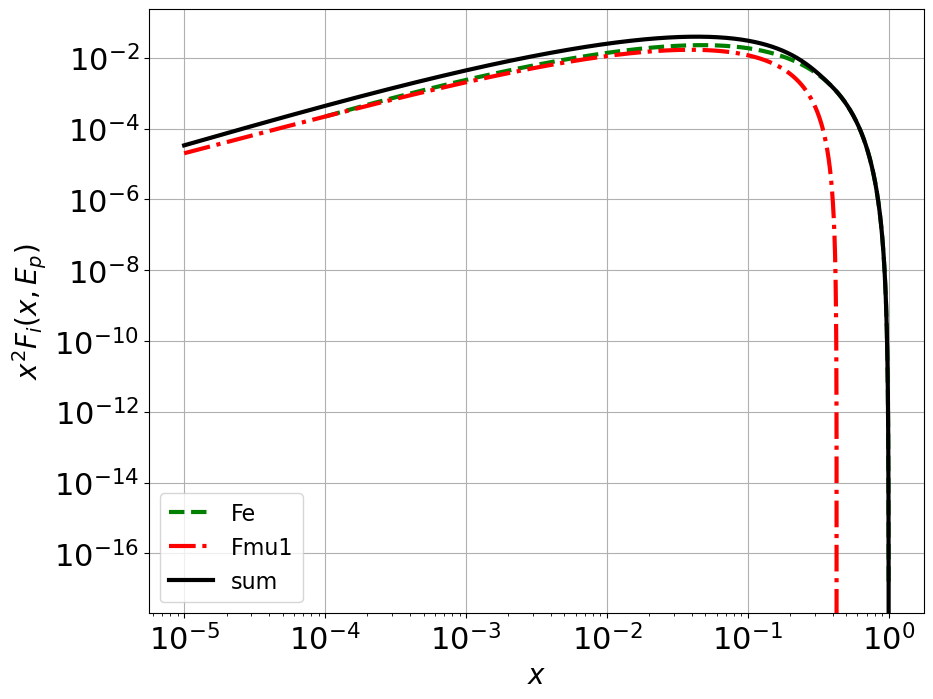

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.cosmology as Cosmology
from astropy import units as u 
from astropy import constants as const
from ipynb.fs.full.Analytic_neutrino_flux import *
import math
from IPython.display import display
import pandas as pd
import time


### Used GOALS data

## Herschel IR luminosity data

In [2]:
Herschel = np.loadtxt("/Users/yarno/documents/PhD/GOALS/SplitLIR/goals_herschel_sample_list.txt")

Split LIR values: https://goals.ipac.caltech.edu/data_files/Lir_LirSurfaceDensity.dat -> IDs missing: 45, 46 , 78, 83, 110, 150, 157,  159 ,187, and 189 + 92 & 238 NaN values. This results in LIR values for 229 galaxies. Note the GOALS sample consists of 202 objects. See also the paper related to the analysis: https://ui.adsabs.harvard.edu/abs/2017ApJ...846...32D/abstract
 
Names corresponding to the iDS in the above file: https://goals.ipac.caltech.edu/data_files/goals_herschel_pacs_CII158_linecatalog_HIPEv13.dat

The redshift and luminosity distance values can be found in "/Users/yarno/documents/PhD/GOALS/goals_herschel_sample_list.txt"

In [3]:
LIR_split_array = np.loadtxt("/Users/yarno/documents/PhD/GOALS/SplitLIR/lir_split.txt", skiprows=0)
LIR_split = [i[1] for i in LIR_split_array]
LIR_split_unc = [i[2] for i in LIR_split_array]
ID = [int(i[0]) for i in LIR_split_array]

LIR_irg = [i[1] for i in LIR_split_array if i[1] < 1]
LIR_lirg = [i[1] for i in LIR_split_array if i[1] >= 1 and i[1] < 10]
LIR_ulirg = [i[1] for i in LIR_split_array if i[1] >= 10]

SigmaIR = [i[3] for i in LIR_split_array ]
SigmaIR_noNaN = []
for i in SigmaIR:
    if math.isnan(i) == False:
        SigmaIR_noNaN += [i]
    else: 
        SigmaIR_noNaN += [0]



## Individual  $\langle \alpha_{\mathrm{AGN}} \rangle$ distribution

In [4]:
fig3 = plt.figure(figsize=(10,9))

AGN_split_array = np.loadtxt("/Users/yarno/documents/PhD/GOALS/SplitLIR/agn_split.txt", skiprows=0)
agn_fracs_unc = [i[1] for i in AGN_split_array]
agn_fracs = [i[0] for i in AGN_split_array]
median_ang_frac = np.median(agn_fracs)


agn_fracs = np.array(agn_fracs)


<Figure size 720x648 with 0 Axes>

The AGN values can be found in Table 2 of this article: https://iopscience.iop.org/article/10.3847/1538-4357/aa81d7#apjaa81d7t1 . It is noted that the IDS 45, 46 , 78, 83, 110, 150, 157,  159 ,187 and 189 are already missing and therefore 92 & 238 had to be removed.


Note, that the mid-infrared and bolometric AGN fractions are both derived from the Spitzer low-res spectra, and are therefore representative of the projected physical area covered by the IRS short-low slit, centered on the nucleus. For more distant or point-like GOALS sources (D > ~ 50-100 Mpc), the AGN fractions will be representative of the values for the entire galaxy.  However, for more nearby sources, the true global mid-infrared and bolometric AGN fractions can be significantly smaller than those reported here. For example, the source with an average AGN fraction of one is NGC 1068, the most nearby (~16 Mpc) Seyfert II galaxy. The true global bolometric AGN fraction will therefore, most likely, be lower.

# Constructing a general dataframe

In [2]:
def SNr(LIR): # SN-LIR empirical callibration S. Matilla
    return 2.7e-12*LIR

def SFR(LIR,calib):
    if calib == "Murphy":
        return 3.15e-44*LIR*1e7*3.828e26
    if calib == "Yarno NK":
        return 4.934702e-44*LIR*1e7*3.828e26 
    if calib == "Yarno TH":
        return 1.537522e-44*LIR*1e7*3.828e26

def SNr_IMF(LIR,calib):
    if calib == "Murphy":
        return (1/86.3)*3.88e-44*LIR*1e7*3.828e26
    elif calib == "Yarno NK":
        return 5.428172e-46*LIR*1e7*3.828e26 
    elif calib == "Yarno TH":
        return 4.151310e-46*LIR*1e7*3.828e26


def SFR_unc(alpha, alphaunc, LIR, LIRunc, Acalib,Acalibunc):
    return np.sqrt(pow(Acalib*LIR*alphaunc,2)+pow((1-alpha)*Acalib*LIRunc,2)+ pow((1-alpha)*LIR*Acalibunc,2))


The callibration for the SFR is based on 33GHz continuum data for 56 nuclei and 62 extranuclear regions for star-forming galaxies covering a wide range of integrated properties, ISM conditions, morphological types, IR luminosity range, and and star-formation rates. The Median value for the ratio between the 33GHz star-formation rate and the IR luminosity are consistent for nuclear and extra-nuclear regions. This empirically determined coefficient is consistent with a theoretical relation given in Murpy et al (2011, SFR = 3.88e-44L$_{IR}$,https://ui.adsabs.harvard.edu/abs/2011ApJ...737...67M/abstract and https://ui.adsabs.harvard.edu/abs/2012ApJ...761...97M/abstract).

In [6]:
a_file = open("/Users/yarno/documents/PhD/GOALS/SplitLIR/IDS.txt", "r")

list_of_lists = [] 
for line in a_file:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    list_of_lists.append(line_list)
missing = [45, 46 , 78, 83,92, 110, 150, 157,  159 ,187, 189,238]

l = [[int(i[0]),i[1],i[6],i[7]] for i in list_of_lists if int(i[0]) not in missing]
l2 = [[i[3],i[4]] for i in Herschel if int(i[0]) not in missing]

dec_l_rad = np.array([i[2] for i in Herschel if int(i[0]) not in missing ])*0.0174532925

chars = [
    
          [
        
          ID[i],
          
          round(np.log10(LIR_split[i]*1e11),2), 
          
          round(np.log10(LIR_split_unc[i]*1e11),2), 
          
          agn_fracs[i], 
          
          agn_fracs_unc[i], 
          
          round(SFR((1-agn_fracs[i])*LIR_split[i]*1e11,"Yarno NK"),2),
          
          round(SFR_unc(agn_fracs[i], agn_fracs_unc[i], LIR_split[i]*1e11*1e7*3.828e26, LIR_split_unc[i]*1e11*1e7*3.828e26, 3.15e-44, 3.15e-44/2),2),
          
          round(SFR(LIR_split[i]*1e11,"Yarno NK"),2) ,
              
          SigmaIR[i]
          
         ]
         
          for i in range(len(ID)) if ID[i] != 92 and ID[i] != 238 
         ]

    
for i in range(len(chars)): 
    chars[i].insert(1,l[i][1])
    chars[i].insert(2,l[i][2])
    chars[i].insert(3,l[i][3])
    chars[i].insert(4,l2[i][0])
    chars[i].insert(5,l2[i][1])


In [8]:
E = 1e3
nism = 1000 
R = 150
v= 500
pmax = 1e8
H = 150
df = pd.DataFrame({ 'Name' : [i[1] for i in l],
        
        'RA' : [i[2] for i in l ],
        
        'Dec' : [i[3] for i in l],
                   
        'Redshift': [i[4] for i in chars],
        
        'D_L [Mpc]' : [ i[5] for i in chars],
        
        'log(LIR)' : [i[6] for i in chars],
        
        'log(LIR_unc)' : [i[7] for i in chars],
        
        'AGNbol' : [i[8] for i in chars],
        
        'AGNbol_unc' : [i[9] for i in chars],
        
        'SFR [M$_{\odot}$]' : [i[10] for i in chars ],
        
        'SFR_unc [M$_{\odot}$]' : [i[11] for i in chars ],
                   
        'un-corr SFR [M$_{\odot}$]':[i[12] for i in chars ] ,
                   
        'Supernova rate [yr$^{-1}$] ' : [SNr_IMF((1-i[8])*pow(10,i[6]), "Yarno NK") for i in chars],
                   
        'un-corr Supernova rate [yr$^{-1}$] ' : [SNr_IMF(pow(10,i[6]), "Yarno NK") for i in chars],
        
        'Flux(TeV) [GeV cm$^{-2}$ s$^{-1}$]': [Flux(1e3,R,v,nism,H,4,pmax,SNr_IMF((1-i[8])*pow(10,i[6]), "Yarno NK"),i[5]) for i in chars],
                                                                 
        'Flux(TeV) no AGN [GeV cm$^{-2}$ s$^{-1}$]': [Flux(1e3,R,v,nism,H,4,pmax,SNr_IMF(pow(10,i[6]), "Yarno NK"),i[5]) for i in chars],
                   
        'SigmaIR (x 10$^{10}$ )': [abs(i[13]) for i in chars],
                   
        'R_70 (kpc)': [np.sqrt((pow(10,i[6])/2)/(10**10*abs(i[13])*np.pi)) for i in chars]
        
                    
       }, index = [i[0] for i in chars])

pd.set_option('display.max_rows', 500)

display(df)
#'Flux(TeV) [GeV cm$^{-2}$ s$^{-1}$]': [bulk_flux(E, nism, R, 0,v, 0.001,1e9, 4.0, pmax, SNr_IMF((1-i[8])*pow(10,i[6]),"Yarno NK"),i[5])[0] for i in chars],
# this flux prediction uses the delta-approximation

,Name,RA,Dec,Redshift,D_L [Mpc],log(LIR),log(LIR_unc),AGNbol,AGNbol_unc,SFR [M$_{\odot}$],SFR_unc [M$_{\odot}$],un-corr SFR [M$_{\odot}$],Supernova rate [yr$^{-1}$],un-corr Supernova rate [yr$^{-1}$],Flux(TeV) [GeV cm$^{-2}$ s$^{-1}$],Flux(TeV) no AGN [GeV cm$^{-2}$ s$^{-1}$],SigmaIR (x 10$^{10}$ ),R_70 (kpc)
0,NGC0023,00h09m53.32s,+25d55m26.2s,0.01523,65.2,11.11,9.71,0.09,0.04,22.30,7.17,24.50,0.243594,0.267686,6.241424e-12,6.858708e-12,2.048,1.000564
1,NGC0034a,00h11m06.59s,-12d06m25.5s,0.01962,84.1,11.50,9.90,0.04,0.02,57.74,18.47,60.15,0.630807,0.657091,9.714417e-12,1.011918e-11,79.180,0.252117
2,MCG-02-01-051a,00h18m50.87s,-10d22m36.6s,0.02722,117.5,11.67,9.94,0.07,0.05,82.41,26.47,88.61,0.903875,0.971909,7.130906e-12,7.667641e-12,9.730,0.874689
3,ESO350-IG038,00h36m52.20s,-33d33m20.8s,0.02060,89.0,11.28,9.97,0.23,0.09,27.53,9.07,35.76,0.304871,0.395936,4.192260e-12,5.444494e-12,7.641,0.629992
4,NGC0232a,00h42m45.80s,-23d33m42.0s,0.02217,95.2,11.48,10.48,0.09,0.03,51.55,16.82,56.65,0.571041,0.627517,6.862858e-12,7.541602e-12,10.697,0.670315
5,NGC0232b,00h42m52.78s,-23d32m28.9s,0.02217,95.2,10.64,9.71,0.47,0.06,4.33,1.45,8.16,0.048073,0.090704,5.777494e-13,1.090093e-12,NaN,NaN
6,MCG+12-02-001,00h54m03.48s,+73d05m03.8s,0.01570,69.8,11.49,9.76,0.06,0.04,54.51,17.47,57.99,0.603606,0.642134,1.349443e-11,1.435578e-11,10.264,0.692232
7,NGC0317B,00h57m40.41s,+43d47m32.9s,0.01811,77.8,11.23,9.59,0.05,0.02,30.47,9.74,32.08,0.335235,0.352879,6.032564e-12,6.350067e-12,24.822,0.329983
8,IC1623AB,01h07m47.49s,-17d30m27.1s,0.02007,85.5,11.73,9.95,0.12,0.04,89.43,28.68,101.63,0.981993,1.115901,1.463147e-11,1.662667e-11,7.663,1.056114
9,MCG-03-04-014,01h10m08.98s,-16d51m09.7s,0.03349,144.0,11.62,10.02,0.07,0.04,73.03,23.42,78.53,0.805580,0.866215,4.231511e-12,4.550012e-12,3.390,1.398976
